In [24]:
import sys 
import os
sys.path.append("../eyeprep/utils")
from eyetrack_utils import (
    load_event_files,              # Load EyeLink event files
    extract_data,                  # Extract data from raw files
    blinkrm_pupil_off,             # Remove blinks with direct pupil detection
    blinkrm_pupil_off_smooth,      # Remove blinks with pupil detection and gaussian kernel 
    interpol_nans,                 # Interpolate missing values
    detrending,                    # Remove trends from signal
    downsample_to_targetrate,      # Change sampling rate
    moving_average_smoothing,      # Smooth with moving average
    gaussian_smoothing,            # Smooth with Gaussian kernel
    extract_eye_data_and_triggers, # Extract gaze and trial timing
    convert_to_dva                 # Convert to degrees of visual angle
)

from settings_utils import load_settings        # Load yml settings function 

from plot_utils import interactive_preproc_plot # Load plotting function for visualization 

from quality_check_utils import compute_residuals

import json
import numpy as np
import h5py
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import matplotlib.pyplot as plt

In [30]:
# Define experiment parameters and load configuration settings


EYEPREP_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
main_dir = os.path.abspath(os.getcwd())
project_dir = "data"
subject = "sub-01"
task = "SacLoc"  # Saccade localization task

# get settings 
general_settings_path = os.path.abspath(os.path.join(main_dir, "../eye-tracking.yml"))
task_settings_path = os.path.abspath(os.path.join(main_dir, f"../eye-tracking_{task}.yml"))
settings = load_settings([general_settings_path, task_settings_path])
analysis_info = settings[0]

ses = analysis_info["session"]
eye = analysis_info["eye"]


In [44]:
print(EYEPREP_ROOT)

/Users/sinakling/disks/meso_H/projects/eyeprep


## Data Extraction

We recorded eyetracking data (.edf) and converted them to tsv.gz files accompanied by metadata json files. Now we can extract the data into readable pandas dataframes and use messages and timestamps to only look at experiment relevant data. 

### Read the data in

In [10]:
def extract_event_and_physio_data(main_dir, project_dir, subject, task, ses, num_run, eye):
    """
    Extract both event timing and physiological data from raw eye tracking files.
    
    Parameters:
    -----------
    main_dir : str
        Root directory containing all study data
    project_dir : str
        Project-specific subdirectory
    subject : str
        Subject ID (e.g., 'sub-01')
    task : str
        Task name (e.g., 'SacLoc' for saccade localization)
    ses : str
        Session ID (e.g., 'ses-01')
    num_run : int
        Number of runs to load
    eye : str
        Which eye to analyze ('eye1' or 'eye2')
    
    Returns:
    --------
    df_event_runs : list of DataFrames
        Event timing data (trial onsets, offsets, etc.)
    df_data_runs : list of DataFrames
        Raw physiological data (gaze position, pupil size, timestamps)
    """
    df_event_runs, event_file_names = extract_data(main_dir, project_dir, subject, task, ses, num_run, eye, file_type="physioevents") # check utils to find this function! 
    df_data_runs, data_file_names = extract_data(main_dir, project_dir, subject, task, ses, num_run, eye, file_type="physio")
    return df_event_runs, event_file_names, df_data_runs, data_file_names

In [4]:
df_event_runs,event_file_names, df_data_runs, data_file_names = extract_event_and_physio_data(
    main_dir, project_dir, subject, task, ses, 
    analysis_info['num_run'], eye
)

print(f"Loaded {len(df_data_runs)} runs of eye tracking data")
print(f"Data is stored in a list, each run is one element. Lets look at the data from run 1:")
print(df_data_runs[0].head())



Loaded 2 runs of eye tracking data
Data is stored in a list, each run is one element. Lets look at the data from run 1:
   timestamp  x_coordinate  y_coordinate  pupil_size
0   13084637        1032.7         563.2      9087.0
1   13084638        1040.2         562.4      9083.0
2   13084639        1055.1         560.1      9080.0
3   13084640        1055.8         560.0      9078.0
4   13084641        1058.7         576.7      9077.0


In [6]:
print(event_file_names)

['sub-01_ses-01_task-SacLoc_run-01_recording-eye1_physioevents.tsv.gz', 'sub-01_ses-01_task-SacLoc_run-02_recording-eye1_physioevents.tsv.gz']


### Extract experiment timing 
Timestamps are in milliseconds relative to the eyetracker. By looping through the message data (df_event_runs) we can extract the timestamp for the first and last trials ("first trial pattern"/"last trial pattern") and use this to filter our actual data (df_data_runs). Finally we can convert the timestamps into seconds. 

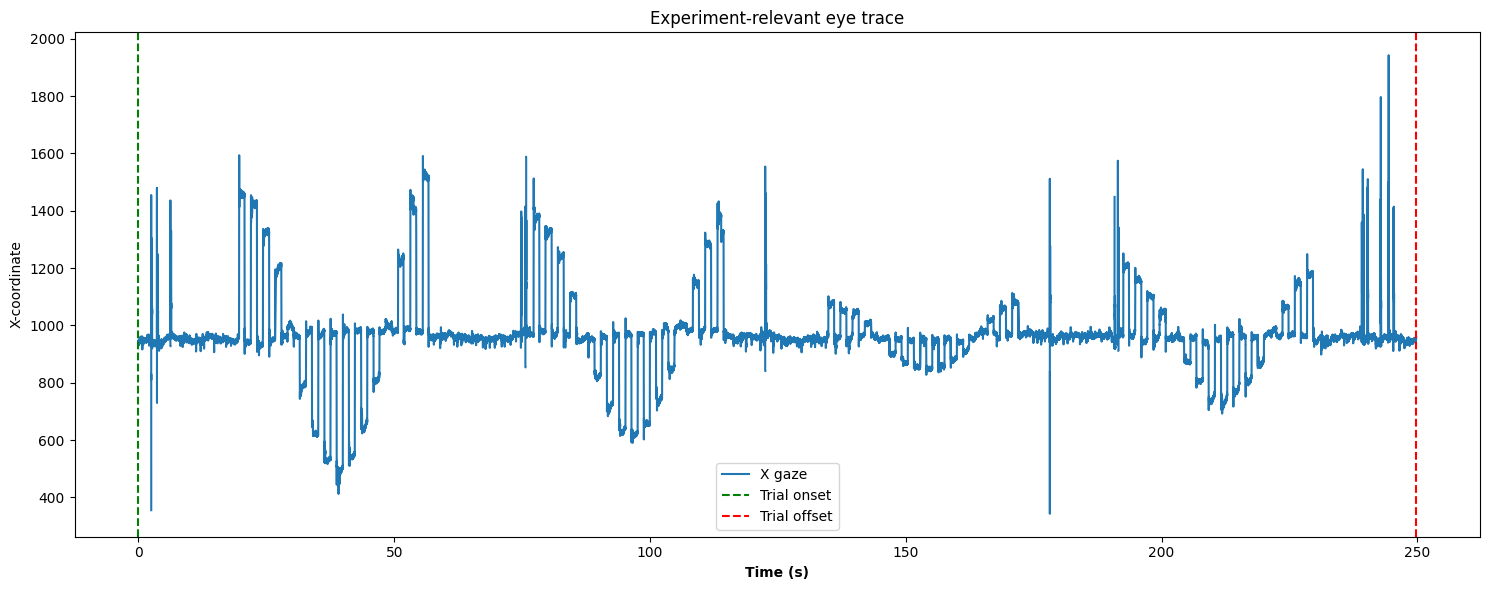

Recording duration: 335.3 seconds
First trial onset at: 81.379


In [10]:
# Align eye tracking data with experimental trial timing

# Extract gaze data and trial trigger times
eye_data_run, time_start_eye, time_end_eye = extract_eye_data_and_triggers(
    df_event_runs[0], 
    df_data_runs[0],
    analysis_info['first_trial_pattern'], 
    analysis_info['last_trial_pattern']
)

# Convert timestamps to seconds (easier to work with than milliseconds)
eye_times = (df_data_runs[0]['timestamp'] - df_data_runs[0]['timestamp'][0]) * 1e-3
eye_times = eye_times.to_numpy()

# Convert trial onset times to seconds relative to first eye sample
trial_onsets_sec = (time_start_eye - df_data_runs[0]['timestamp'][0]) * 1e-3

print(f"Recording duration: {eye_times[-1]:.1f} seconds")
print(f"First trial onset at: {(trial_onsets_sec)}")


## First preprocessing 
Awesome. Lets get this signal clean. We will apply the first preprocessing steps. 
1. Remove Blinks 
2. Convert to dva 
3. Interpolate NaNs 
4. Normalise pupil data 

In [11]:
def remove_blinks(data, method, sampling_rate):
    """
    Remove blink artifacts from eye tracking data.
    
    Blinks cause temporary invalid gaze measurements. We remove them by either:
    - pupil_off: Replace blink periods with NaN (pupil disappears during blinks)
    - pupil_off_smooth: Replace and smooth the transition
    
    Parameters:
    -----------
    data : ndarray
        Eye tracking data array
    method : str
        Which blink removal method to use
    sampling_rate : int
        Eye tracker sampling rate (Hz, e.g., 500)
    
    Returns:
    --------
    data : ndarray
        Data with blinks removed (replaced with NaN or smoothed)
    """
    if method == 'pupil_off':
        return blinkrm_pupil_off(data, sampling_rate)
    elif method == 'pupil_off_smooth':
        return blinkrm_pupil_off_smooth(data, sampling_rate)
    else:
        print("Warning: No blink removal method specified. Returning original data.")
        return data


def drift_correction(data, method, fixation_periods):
    """
    Correct for eye tracker drift over time.
    
    Eye trackers lose calibration during recording, causing the measured gaze
    position to drift. We correct this by:
    - linear: Fit a line and remove the trend
    - median: Use median gaze position during fixations as reference
    
    Parameters:
    -----------
    data : ndarray
        Eye tracking data
    method : str
        Drift correction method ('linear' or 'median')
    fixation_periods : list
        Time indices of known fixations (for median method)
    
    Returns:
    --------
    data : ndarray
        Drift-corrected data
    """
    if method == "linear":
        return detrending(data, type='linear')
    elif method == 'median':
        fixation_median = np.median([item for row in fixation_periods for item in row])
        return np.array([elem - fixation_median for elem in data])
    else:
        print("Warning: No drift correction method specified. Returning original data.")
        return data


def interpolate_nans(data):
    """
    Fill in missing data points (NaN values).
    
    After removing blinks, we have gaps in our data. Linear interpolation
    estimates the missing values based on surrounding data points.
    
    Parameters:
    -----------
    data : ndarray
        Data with NaN values
    
    Returns:
    --------
    data : ndarray
        Data with NaN values interpolated
    """
    return interpol_nans(data)


def normalize_data(data):
    """
    Normalize pupil size to a standard range.
    
    Pupil size varies across subjects and sessions due to lighting conditions
    and individual differences. Normalization (scaling) makes data comparable.
    
    We scale to [-1, 1] so that values are centered at 0 with equal ranges
    on both sides (useful for neural networks and other ML methods).
    
    Parameters:
    -----------
    data : ndarray
        Raw pupil size data
    
    Returns:
    --------
    data : ndarray
        Normalized pupil size
    """
    print('- normalizing pupil data to [-1, 1]')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(data.reshape(-1, 1)).flatten()

- blink replacement with NaN


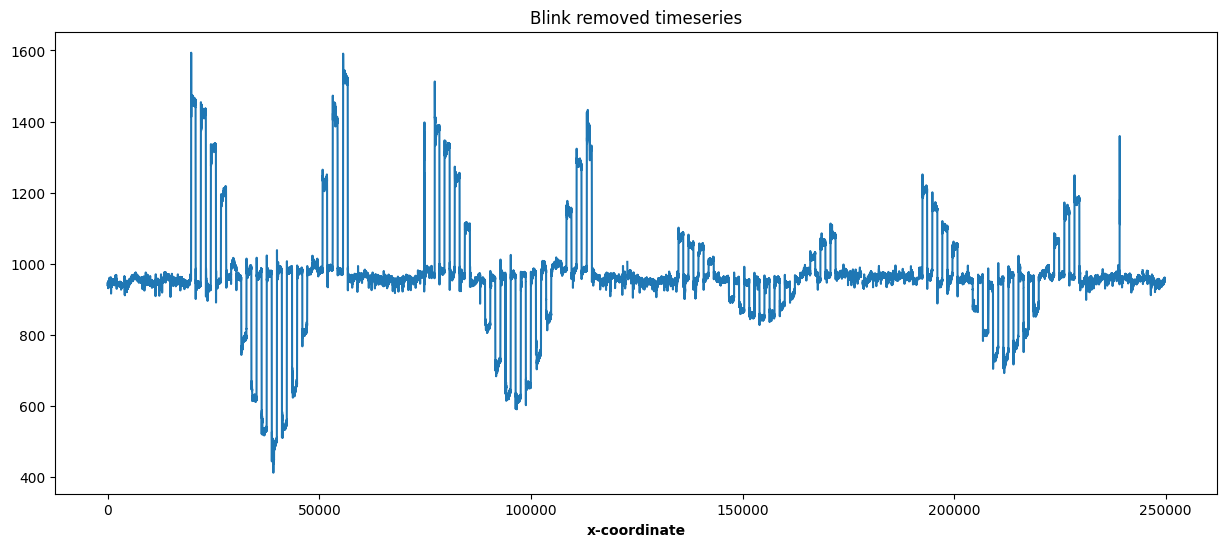

✓ Blinks removed


In [12]:
# STEP 1: Remove blinks
# Blinks cause the pupil to disappear and gaze data to be unreliable
eye_data_run_blinks = remove_blinks(
    eye_data_run, 
    analysis_info['blinks_remove'],      # Method specified in config
    analysis_info['eyetrack_sampling']   # Sampling rate (Hz)
)
print("✓ Blinks removed")


In [13]:
# Step 2: Convert to dva 
# Transform from pixel coordinates to a viewer-independent measure: Dva ~ rotation angle of the eye 
# attention: run this only once ;)
eye_data_run_dva = convert_to_dva(eye_data_run_blinks, analysis_info['center'], analysis_info['ppd'])

print("Lets have a look at our gaze on the screen now. Run the next cell to see!")


Lets have a look at our gaze on the screen now. Run the next cell to see!


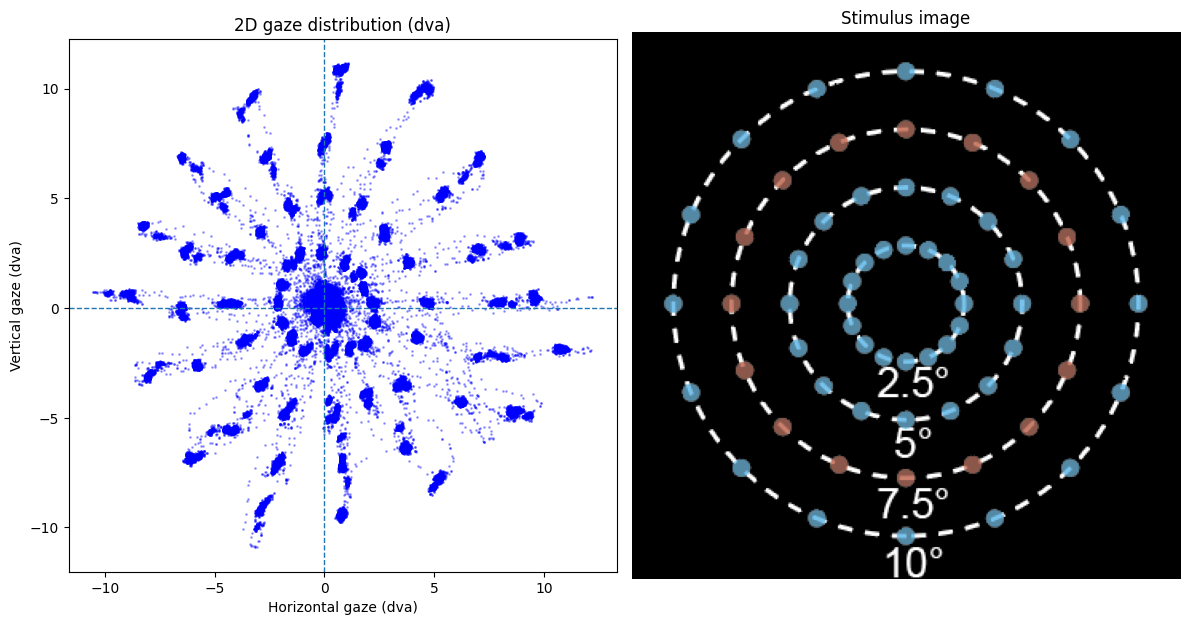

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load your image
img = mpimg.imread(f'{EYEPREP_ROOT}/docs/images/{task}_design.png')  

# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: gaze scatter plot ---
axes[0].scatter(
    eye_data_run_dva[:,1],
    eye_data_run_dva[:,2],
    s=1,
    alpha=0.3,
    color='blue'
)
axes[0].axhline(0, linestyle='--', linewidth=1)
axes[0].axvline(0, linestyle='--', linewidth=1)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('Horizontal gaze (dva)')
axes[0].set_ylabel('Vertical gaze (dva)')
axes[0].set_title('2D gaze distribution (dva)')

# --- Right: image ---
axes[1].imshow(img)
axes[1].axis('off')  # hide axes
axes[1].set_title('Stimulus image')

plt.tight_layout()
plt.show()



In [15]:
# STEP 3: Interpolate NaNs for each channel
eye_data_run_x = interpolate_nans(eye_data_run_blinks[:, 1])
eye_data_run_y = interpolate_nans(eye_data_run_blinks[:, 2])
eye_data_run_p = interpolate_nans(eye_data_run_blinks[:, 3])
print("✓ Missing values interpolated")
# STEP 4: Normalise pupil data 
eye_data_run_p_normalized = normalize_data(eye_data_run_p)
print("✓ Pupil data normalized")

# Stack it all back together
eye_data_run_interpolated = np.stack((eye_data_run[:,0],
                                 eye_data_run_x, 
                                 eye_data_run_y, 
                                 eye_data_run_p_normalized), axis=1)

- interpolating data
- interpolating data
- interpolating data
✓ Missing values interpolated
- normalizing pupil data to [-1, 1]
✓ Pupil data normalized


In [16]:
# TESTING NOISE QUANTIFICATION 

#TODO: add new function (that doesnt overwrite)
def moving_average_smoothing(df, eyetracking_rate, window_duration_ms): 
    """
    Apply moving average smoothing to eye-tracking data using a specified window size.

    Args:
        dataframe (pd.DataFrame): Eye-tracking data with 'x' and 'y' columns.
        eyetracking_rate (int): Sampling rate of the data.
        window_duration (int): Duration of the moving average window in milliseconds.

    Returns:
        pd.DataFrame: Smoothed data with rolling averages applied to X and Y coordinates.
    """
    window_size = int(eyetracking_rate * (window_duration_ms / 1000))

    smoothed = df.copy()
    smoothed['x'] = (
        df['x']
        .rolling(window=window_size, center=True)
        .mean()
    )
    smoothed['y'] = (
        df['y']
        .rolling(window=window_size, center=True)
        .mean()
    )

    return smoothed



In [17]:
def gaussian_smoothing(df, sigma, columns = ['x', 'y']):
    """
    Apply Gaussian smoothing to specified columns in a dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing eye-tracking data.
        columns (list or tuple of str): Column names to smooth (e.g., ['x', 'y']).
        sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
        pd.DataFrame: A copy of the dataframe with smoothed columns.
    """
    from scipy.ndimage import gaussian_filter1d

    df_smoothed = df.copy()

    for col in columns:
        df_smoothed[col] = gaussian_filter1d(
            df_smoothed[col].to_numpy(),
            sigma=sigma
        )

    return df_smoothed


In [18]:
import pandas as pd 
eye_data_run_interpolated = pd.DataFrame(eye_data_run_interpolated, columns=['timestamp', 'x', 'y', 'pupil_size'])
eye_data_run_smoothed = moving_average_smoothing(eye_data_run_interpolated, analysis_info['eyetrack_sampling'], analysis_info['window'])

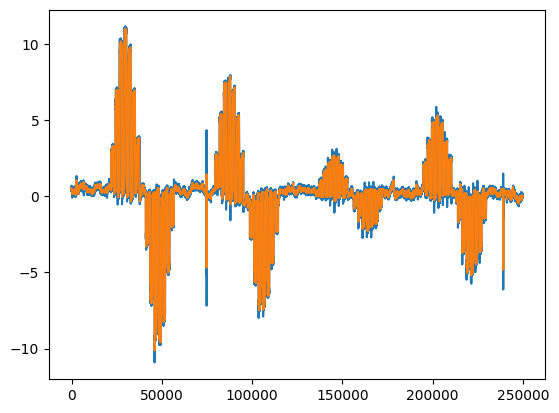

In [19]:
plt.plot(eye_data_run_interpolated['y'])
plt.plot(eye_data_run_smoothed['y'])

In [33]:
import numpy as np
import pandas as pd

def rms_s2s(df):
    """
    Compute RMS-S2S (root mean square of sample-to-sample displacements) for 2D gaze.

    Args:
        df (pd.DataFrame): Eye-tracking data with columns 'x' and 'y' (degrees of visual angle)

    Returns:
        float: RMS-S2S in degrees
    """
    # Compute successive differences
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    
    # Euclidean distance between successive samples
    displacements = np.sqrt(dx**2 + dy**2)
    
    # RMS-S2S
    return np.sqrt(np.mean(displacements**2))


In [34]:
rms2s = rms_s2s(eye_data_run_interpolated)
print(rms2s)

0.0879569468882361


In [ ]:
import numpy as np

def signal_magnitude(df, df_smoothed):
    """
    Compute combined signal magnitude from RMS-S2S and STD.

    Args:
        df (pd.DataFrame): Raw eye-tracking data with columns 'x', 'y'
        df_smoothed (pd.DataFrame): Smoothed eye-tracking data with columns 'x', 'y'

    Returns:
        dict: Signal magnitude for x, y, and combined (Euclidean)
    """
    # 2d standard deviation
    std_x = np.nanstd(df['x'])
    std_y = np.nanstd(df['y'])
    
    # Combine x and y into a single scalar
    std_2d = np.sqrt(std_x**2 + std_y**2)
    
    # RMS-S2S
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    rms_s2s_x = np.sqrt(np.mean(dx**2))
    rms_s2s_y = np.sqrt(np.mean(dy**2))
    
    # Combine
    sigmag_x = np.sqrt(rms_s2s_x**2 + std_x**2)
    sigmag_y = np.sqrt(rms_s2s_y**2 + std_y**2)
    
    # Combined 2D magnitude
    sigmag_combined = np.sqrt(sigmag_x**2 + sigmag_y**2)
    
    return {
        'x_signal_magnitude': sigmag_x,
        'y_signal_magnitude': sigmag_y,
        'combined_signal_magnitude': sigmag_combined
    }


In [39]:
# Niehorster, D.C., Zemblys, R., Beelders, T. et al. Characterizing gaze position signals and synthesizing noise during fixations in eye-tracking data. Behav Res 52, 2515–2534 (2020). https://doi.org/10.3758/s13428-020-01400-9

import numpy as np
import pandas as pd

def rms_s2s_2d(df):
    """
    Compute RMS-S2S for 2D gaze data.

    Args:
        df (pd.DataFrame): Eye-tracking data with 'x' and 'y' columns (degrees of visual angle)

    Returns:
        float: 2D RMS-S2S in degrees
    """
    # Successive differences
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    
    # Euclidean displacement per sample-to-sample
    displacements = np.sqrt(dx**2 + dy**2)
    
    # RMS of these displacements
    return np.sqrt(np.mean(displacements**2))


def signal_magnitude_2d(df):
    """
    Compute combined 2D signal magnitude: RMS-S2S + residual STD.

    Args:
        df (pd.DataFrame): Raw gaze data with 'x' and 'y'
    Returns:
        float: Signal magnitude (degrees of visual angle)
    """
    # 2D residual STD
    std_2d = np.sqrt(np.nanstd(df['x'])**2 + np.nanstd(df['y'])**2)
    
    # 2D RMS-S2S
    rms2d = rms_s2s_2d(df)
    
    # Combined signal magnitude
    signal_mag = np.sqrt(rms2d**2 + std_2d**2)
    
    return signal_mag, std_2d, rms2d


In [40]:
signal_magnitude, std, rms = signal_magnitude_2d(eye_data_run_interpolated)
print(signal_magnitude, std, rms)

3.639130854973489 3.6380677502094674 0.0879569468882361


In [ ]:
# Final check to see what we did! 
# Play around with the plot 
interactive_preproc_plot(eye_data_run, eye_data_run_blinks, eye_data_run_interpolated, eye_data_run_p_normalized, eye_times)

In [51]:
run_duration = '249.8'
missing_data = 'No missing data points!'

In [ ]:
from string import Template

# Define the HTML template
html_tpl = Template("""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>$title</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }
        h1 { color: #333; }
        h2 { color: #555; margin-top: 30px; }
        h3 { color: #666; margin-top: 20px; }
        p { margin: 10px 0; }
        .figure { margin: 15px 0; }
        .figure img { max-width: 600px; height: auto; }
    </style>
</head>
<body>

<h1>$title</h1>
<h1>Summary</h1
<p>$intro</p>

<h2>Quality Report Overview</h2>
<p>$overview_info</p>
<p>Duration of the run: $duration s</p>

<h2>First sanity check</h2>
<p>Proportion of missing data: $missing_data</p>
<p>$missing_data_check</p>

<h2>Gaze overview</h2>
<p>Plot of 2D gaze on screen - proportion of data outside: </p>
<div class="figure">
    <img src="$gaze_plot" alt="Gaze plot">
</div>

<h2>Blinks/valid data</h2>
<p>Proportion of valid data after blink removal: $valid_data</p>
<div class="figure">
    <img src="$blinks_plot" alt="Blinks over time">
</div>
<p>$blink_description</p>

<h2>Noise</h2>
<p>Standard deviation of residuals: $noise_std</p>
<p>Signal Magnitude: $signal_magnitude</p>

<h2>Preprocessing overview</h2>
<div class="figure">
    <img src="$preprocessing_plot" alt="Timeseries x y pupil">
</div>

<h2>SECTION 5 - Saccade detection overview</h2>
<p>$saccade_info</p>

</body>
</html>
""")

# Substitute values
html_report = html_tpl.substitute(
    title="EyePrep Quality Report",
    intro=f"Info: Processed file: {data_file_names[0]}]",
    duration=f'{run_duration}',
    missing_data=f"{missing_data}",
    missing_data_check="Check that no missing time samples.",
    gaze_plot=f"file://{EYEPREP_ROOT}/docs/images/quality_report_mockup/gaze2Dscatter.png",
    valid_data="valid_data.png",
    blinks_plot=f"file://{EYEPREP_ROOT}/docs/images/quality_report_mockup/blinks.png",
    blink_description="Description of blink length, interblink duration, timing peaks etc.",
    noise_std="0.03",
    signal_magnitude="Signal magnitude details here",
    preprocessing_plot="images/preprocessing_plot.png",
    saccade_info="Quantity, distribution, sequence plot etc (for later)"
)

# Save to file
with open("/Users/sinakling/Desktop/quality_report.html", "w") as f:
    f.write(html_report)

print("HTML report generated!")


HTML report generated!
